In [11]:
import MulensModel as mm
import matplotlib.pyplot as plt
import numpy as np
from param_utils import Param, Params

In [12]:
def get_curve(args):
    my_1S2L_model = mm.Model({'t_0': 0, 'u_0': args[0],
                              't_E': args[1], 'rho': args[2], 'q': args[3], 's': args[4],
                              'alpha': args[5]})
    times = my_1S2L_model.set_times()
    times -= min(times)
    lc = my_1S2L_model.get_lc(source_flux=1)
    return times, lc

In [13]:
u_0 = Param("u_0", 0, np.sqrt(1), 0.5)
print(u_0)
print(u_0.get_sample_n(0, 1, 1))

(array([0.52210077]), array(['u_0: 0.52'], dtype='<U9'))


/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/model.py:267: UserWarning: No blend_flux not specified. Assuming blend_flux = zero.
  warnings.warn(
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


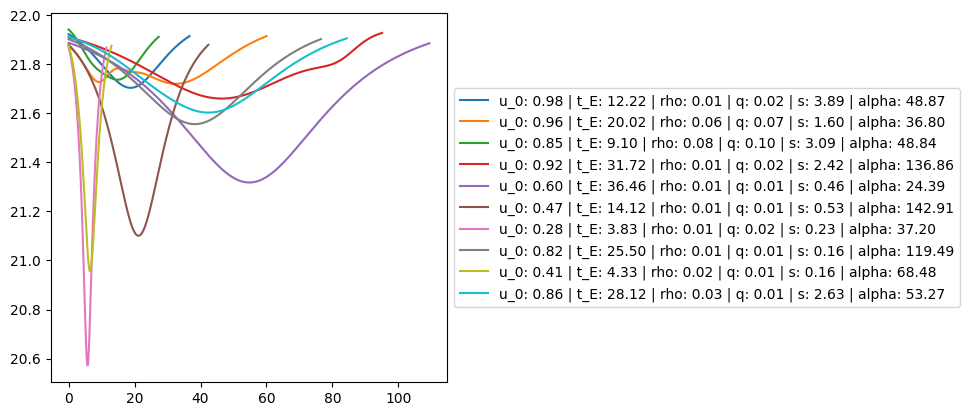

In [14]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(10):
    params = Params()
    args, labels = params.get_vals()
    x, y = get_curve(args)
    ax.plot(x, y, label=' | '.join(labels))
    
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/tmp/ipykernel_92195/3730899978.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 640x480 with 0 Axes>

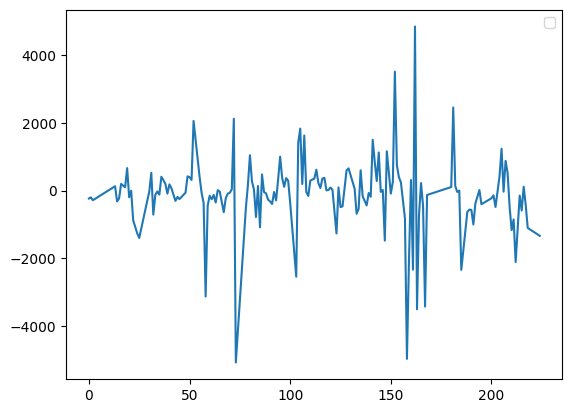

In [41]:
# add random light curve section to star as noise
from tqdm import tqdm
from astropy.io import ascii
import os

fig = plt.figure()
def choose_random_noise_curve(chunk_size=225, outlier_cutoff=2):
    fdir = "data/lightcurves/"
    directory = os.fsencode(fdir)
    files = os.listdir(directory)

    def grab_curve():
        # choose a random light curve
        selection_index = np.random.choice(len(files), replace=False) 
        curve = ascii.read(fdir + os.fsdecode(files[selection_index]), format='ipac')
        
        # grab all real values
        unmasked_inds = curve['cor_flux'].data.nonzero()

        # check there are real values
        if len(unmasked_inds[0]) == 0:
            return grab_curve()
    
        # first real index
        start = unmasked_inds[0][0]
        
        # fill x range to interpolate over
        x_filled = np.arange(curve['HJD'][start], curve['HJD'][start] + chunk_size)

        # grab real data + interpolate + return
        unmasked = curve['cor_flux'].data[unmasked_inds]
        unmasked_time = curve['HJD'][unmasked_inds]
        sample_interpolated = np.interp(x_filled, unmasked_time, unmasked)

        x_filled = x_filled - curve['HJD'][start]
        return x_filled, sample_interpolated

    x_i, y_i = grab_curve()

    # we check for variance with a moving average (faster than FFT methods)
    def moving_average(a, n=20):
        # n = 10 to capture large events (microlensing events) without filtering out noise
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    moving_avg = moving_average(y_i)
    curve_variance = max(moving_avg)
    max_variance = outlier_cutoff * np.std(y_i)
    
    if curve_variance > max_variance:
        print("outliers in our noise curve, grabbing new data")
        x_i, y_i = grab_curve()

    return x_i, y_i

x, curve = choose_random_noise_curve()

fig = plt.figure()
plt.plot(x, curve)
plt.legend()
plt.show()

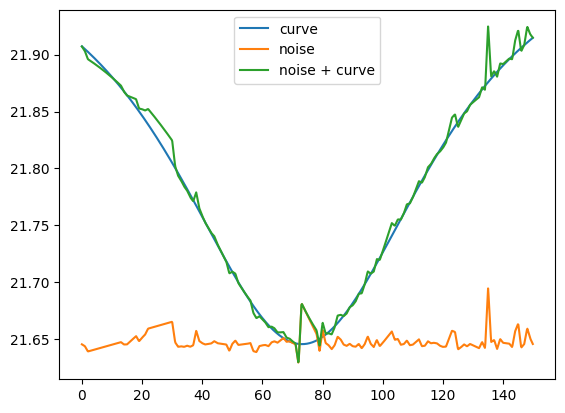

In [ ]:
params = Params()
args, labels = params.get_vals()
x, y = get_curve(args)
noise_x, noise_y = choose_random_noise_curve()

fig = plt.figure()
plt.plot(x, y, label="curve")
noise_interp = np.interp(x, noise_x, noise_y)
noise_small = noise_interp * np.std(y) / (max(noise_y) - min(noise_y))
plt.plot(x, noise_small + min(y), label="noise")
plt.plot(x, y + noise_small, label="noise + curve")
plt.xlabel("Time")
plt.ylabel("Magnitude (mag)")
plt.legend()
plt.show()